# Validation of experiments - using all spindles, training with all data
fistly define the UUID of the experiment to use

In [1]:
experimentId="a74605bf-c0bb-40f7-9b50-444123efb629"

-------------------------------------------------------

In this notebook we have some overall properties of the models trained and how they change with the labeling criterium

In [2]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [3]:
samplerate=200  #Should rethink this

In [4]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [5]:
#consider to include this in a function
minDuration=0.3
maxDuration=2.9
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [6]:
#check with EDA results (not needed)
print(1-len(annotations)/33458)

0.011297746428357902


In [7]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [8]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Load experiment results

In [9]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [10]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",afd523c8-e3bf-44e0-a0c7-85a7b0d747e4,0.016462
1,0001,E1,[0001],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",d90313d0-46a5-4957-b4bd-1c2e66388a31,0.023280
2,0001,E1,[0001],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",825f07e0-9a06-44aa-bb72-93cdd7d64ca2,0.018776
3,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0010, 0011, 0017, 0019]","[0001, 0018, 0014]","[0002, 0006, 0012, 0013]",0b4afad9-a6fb-43ae-8f49-a5d65994e109,0.016077
4,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0010, 0014, 0018, 0019]","[0009, 0011, 0017]","[0002, 0006, 0012, 0013]",bcaeb868-00a0-4038-bc73-fb5d86ea09ee,0.018950
5,0001,E1,[0001],"[0001, 0003, 0007, 0009, 0014, 0017, 0018, 0019]","[0011, 0010, 0005]","[0002, 0006, 0012, 0013]",00a66953-1236-49a2-bbdc-78c361fa15f0,0.019888
6,0001,E1,[0001],"[0001, 0005, 0007, 0010, 0011, 0014, 0017, 0019]","[0018, 0003, 0009]","[0002, 0006, 0012, 0013]",adcf962a-53df-4cb8-ae1f-7a94e2ad3e0c,0.019369
7,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0014, 0018, 0019]","[0010, 0011, 0017]","[0002, 0006, 0012, 0013]",21c95c6e-be0b-49bb-a43b-807238a1b12c,0.019076
8,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0011, 0014, 0017, 0018]","[0001, 0019, 0010]","[0002, 0006, 0012, 0013]",216f16f3-c2d8-4735-bf51-0daed207c25e,0.018514
9,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 0018]","[0017, 0019, 0014]","[0002, 0006, 0012, 0013]",09cbec08-c8af-49fb-aabd-4702bef80265,0.020993


In [11]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                          \
                        count      mean       std       min       25%   
criteriumName                                                           
E1                       10.0  0.019138  0.002063  0.016077  0.018579   
E2                       10.0  0.059377  0.004969  0.054294  0.056372   
union                    10.0  0.060948  0.005032  0.055834  0.058060   

                                             
                    50%       75%       max  
criteriumName                                
E1             0.019013  0.019758  0.023280  
E2             0.057708  0.060940  0.069221  
union          0.059096  0.062695  0.071169

In [12]:
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


## Run a quick test with guessed parameters to see diferences between labelers

In [13]:
hyperClose=0.25
hyperDuration=0.3
hyperTrees=20
hyperThres=0.5
hyperExperimentModels=[]

In [14]:
meanF1=[]
meanPrecision=[]
meanRecall=[]
rawMeanF1=[]
rawMeanPrecision=[]
rawMeanRecall=[]

stdF1=[]
stdPrecision=[]
stdRecall=[]
rawStdF1=[]
rawStdPrecision=[]
rawStdRecall=[]

In [15]:
for ind,row in experimentModels.iterrows():
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)
    #initialise lists
    rawF1s=[]
    rawPrecisions=[]
    rawRecalls=[]
    #rawFprs=[]
    f1s=[]
    precisions=[]
    recalls=[]
    #fprs=[]

    #iterate validation subjects
    for valSubjectId in row.val:
        #Define annotations criterium
        usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
        #Load features and labels
        valFeatures=loadFeatureMatrix([valSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
        valLabels=loadLabelsVector([valSubjectId],usedAnnotations,signalsMetadata,samplerate)
        #Predict
        valDMatrix=xgb.DMatrix(data=valFeatures)
        probabilities=model.predict(valDMatrix,iteration_range=(0,hyperTrees))
        rawLabels=probabilities>=hyperThres
        #Raw Metrics
        rawTp=np.sum(rawLabels*valLabels)
        rawFp=np.sum(rawLabels*(1-valLabels))
        rawTn=np.sum((1-rawLabels)*(1-valLabels))
        rawFn=np.sum((1-rawLabels)*valLabels)
        rawF1=2*rawTp/(2*rawTp+rawFp+rawFn)
        rawPrecision=rawTp/(rawTp+rawFp) 
        rawRecall=rawTp/(rawTp+rawFn)
        #rawFpr=rawFp/(rawFp+rawFn)
        #Raw appends
        rawF1s.append(rawF1)
        rawPrecisions.append(rawPrecision)
        rawRecalls.append(rawRecall)
        #rawFprs.append(rawFpr)
        #Process
        processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)
        #Processed metrics
        tp=np.sum(processedLabels*valLabels)
        fp=np.sum(processedLabels*(1-valLabels))
        tn=np.sum((1-processedLabels)*(1-valLabels))
        fn=np.sum((1-processedLabels)*valLabels)
        f1=2*tp/(2*tp+fp+fn)
        precision=tp/(tp+fp)
        recall=tp/(tp+fn)
        #fpr=fp/(fp+tn)
        #Processed appends
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        #fprs.append(fpr)

    #statistics of the metrics over the subjects of the validation set
    meanF1.append(np.mean(f1s))
    meanPrecision.append(np.mean(precisions))
    meanRecall.append(np.mean(recalls))
    rawMeanF1.append(np.mean(rawF1s))
    rawMeanPrecision.append(np.mean(rawPrecisions))
    rawMeanRecall.append(np.mean(rawRecalls))

    stdF1.append(np.std(f1s))
    stdPrecision.append(np.std(precisions))
    stdRecall.append(np.std(recalls))
    rawStdF1.append(np.std(rawF1s))
    rawStdPrecision.append(np.std(rawPrecisions))
    rawStdRecall.append(np.std(rawRecalls))


In [16]:
experimentModels['meanF1']=meanF1
experimentModels['meanPrecision']=meanPrecision
experimentModels['meanRecall']=meanRecall
experimentModels['rawMeanF1']=rawMeanF1
experimentModels['rawMeanPrecision']=rawMeanPrecision
experimentModels['rawMeanRecall']=rawMeanRecall

experimentModels['stdF1']=stdF1
experimentModels['stdPrecision']=stdPrecision
experimentModels['stdRecall']=stdRecall
experimentModels['rawStdF1']=rawStdF1
experimentModels['rawStdPrecision']=rawStdPrecision
experimentModels['rawStdRecall']=rawStdRecall

In [18]:
experimentModels[['criteriumName','meanF1','stdF1','rawMeanF1','rawStdF1']].groupby('criteriumName').describe()

meanF1                                                    \
               count      mean       std       min       25%       50%   
criteriumName                                                            
E1              10.0  0.523556  0.078461  0.354849  0.509432  0.522548   
E2              10.0  0.581677  0.057271  0.452904  0.568722  0.587858   
union           10.0  0.598089  0.056636  0.470254  0.587402  0.606826   

                                  stdF1            ... rawMeanF1            \
                    75%       max count      mean  ...       75%       max   
criteriumName                                      ...                       
E1             0.592242  0.598188  10.0  0.091715  ...  0.562830  0.584632   
E2             0.619074  0.651894  10.0  0.090800  ...  0.581650  0.616317   
union          0.629858  0.672415  10.0  0.087877  ...  0.600165  0.634507   

              rawStdF1                                                    \
                 count      mean       std       min       25%       50%   
criteriumName                                                              
E1                10.0  0.094286  0.050809  0.011787  0.064172  0.086912   
E2                10.0  0.098692  0.032317  0.056614  0.081372  0.089760   
union             10.0  0.097817  0.033766  0.051714  0.081094  0.090153   

                                   
                    75%       max  
criteriumName                      
E1             0.124577  0.170351  
E2             0.121185  0.155302  
union          0.121498  0.153421  

[3 rows x 32 columns]

In [21]:
fig=px.scatter(experimentModels,x='rawMeanF1',y='meanF1',color='criteriumName',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawMeanF1'], y=experimentModels['rawMeanF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

### CODA: visulise some of the latest model validation

In [24]:
experimentModels.iloc[len(experimentModels)-1]

criteriumId                                                     0003
criteriumName                                                  union
labelerIdList                                           [0001, 0002]
train               [0001, 0003, 0005, 0007, 0009, 0010, 0011, 0018]
val                                               [0017, 0019, 0014]
test                                        [0002, 0006, 0012, 0013]
modelId                         ff520954-f5f8-40cf-a6d9-4ccfb90c53be
spindleTimeRate                                             0.063421
meanF1                                                      0.625758
meanPrecision                                               0.624928
meanRecall                                                  0.685025
rawMeanF1                                                   0.618308
rawMeanPrecision                                            0.651647
rawMeanRecall                                               0.639544
stdF1                             

In [34]:
print(f1)
print(precision)
print(recall)

0.6169037190947413
0.4930078440566301
0.8239732061524024


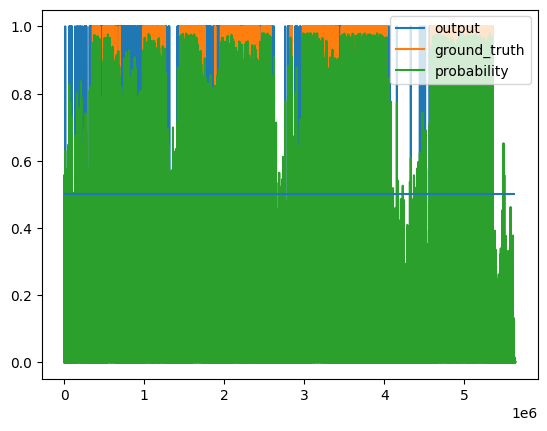

In [32]:
plt.plot(processedLabels)
plt.plot(valLabels)
plt.plot(probabilities)
plt.legend(['output','ground_truth','probability'],loc='upper right')
plt.hlines(hyperThres,xmin=0,xmax=len(probabilities))


In [26]:
f1s

[0.5881279406496003, 0.6722421409821372, 0.6169037190947413]

In [27]:
precisions

[0.7781048353305958, 0.6036702588297861, 0.4930078440566301]

In [28]:
recalls

[0.4727133879564076, 0.7583887466876131, 0.8239732061524024]